Epoch 1/10


d:\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0966 - mae: 0.2463
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0369 - mae: 0.1541
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0276 - mae: 0.1290
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0138 - mae: 0.0916
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0094 - mae: 0.0777
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0072 - mae: 0.0669
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0042 - mae: 0.0513
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0034 - mae: 0.0449
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0031 - mae: 0.0420
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0028 - mae: 0.0393


✅ Model training complete and saved as pedestrian_detector.h5!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


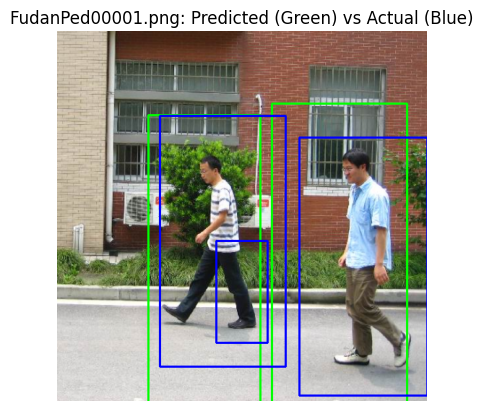

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


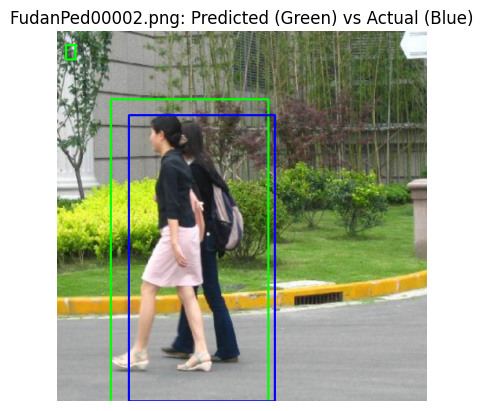

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


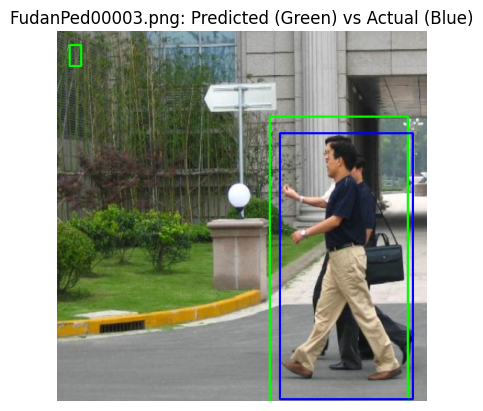

In [ ]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
base_folder = r"D:\VS_PYTHON\ML\pedestrian_dataset"
input_folder = os.path.join(base_folder, "PNGImages")
output_folder = os.path.join(base_folder, "Resized_Images")
json_path = os.path.join(base_folder, "manual_pedestrian_bboxes_New.json")

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Resize constants
original_size = (512, 512)
img_size = (224, 224)
batch_size = 2

# Enhanced pedestrian detection using HOG descriptor
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def detect_pedestrians(image):
    image_resized = cv2.resize(image, original_size)
    rects, _ = hog.detectMultiScale(image_resized, winStride=(4, 4), padding=(8, 8), scale=1.05)
    boxes = []
    for (x, y, w, h) in rects:
        boxes.append({"x": int(x), "y": int(y), "width": int(w), "height": int(h)})
    return boxes

bounding_boxes = {}
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        path = os.path.join(input_folder, filename)
        image = cv2.imread(path)
        if image is None:
            continue
        image = cv2.resize(image, original_size)
        cv2.imwrite(os.path.join(output_folder, filename), image)
        boxes = detect_pedestrians(image)
        bounding_boxes[filename] = boxes

# Save improved bounding boxes
with open(json_path, "w") as json_file:
    json.dump(bounding_boxes, json_file, indent=4)

# Load updated JSON
with open(json_path, "r") as json_file:
    bounding_boxes = json.load(json_file)

class PedestrianDataGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]

        X, y_batch = [], []
        for i, filename in enumerate(batch_images):
            img_path = os.path.join(output_folder, filename)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, img_size)
            image = image / 255.0

            boxes = batch_labels[i]
            selected_boxes = boxes[:2] if len(boxes) >= 2 else boxes + ([{"x": 0, "y": 0, "width": 0, "height": 0}] * (2 - len(boxes)))

            y_data = []
            for box in selected_boxes:
                x_norm = box["x"] / original_size[0]
                y_norm = box["y"] / original_size[1]
                w_norm = box["width"] / original_size[0]
                h_norm = box["height"] / original_size[1]
                y_data.extend([x_norm, y_norm, w_norm, h_norm])

            X.append(image)
            y_batch.append(y_data)

        if len(X) == 0:
            return np.zeros((self.batch_size, 224, 224, 3)), np.zeros((self.batch_size, 8))

        return np.array(X), np.array(y_batch)

# Prepare filenames and labels
image_filenames = list(bounding_boxes.keys())
labels = [bounding_boxes[filename] for filename in image_filenames]
train_generator = PedestrianDataGenerator(image_filenames, labels, batch_size)

# Define CNN model for 2 bounding boxes (2 x 4 = 8 outputs)
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(8, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
model.fit(train_generator, epochs=10)
model.save("pedestrian_detector.h5")

print("Model training complete and saved as pedestrian_detector.h5!")


# Test multiple images
for test_index in range(min(3, len(image_filenames))):
    test_filename = image_filenames[test_index]
    test_img_path = os.path.join(output_folder, test_filename)
    test_img = cv2.imread(test_img_path)
    test_img_resized = cv2.resize(test_img, img_size) / 255.0

    prediction = model.predict(np.expand_dims(test_img_resized, axis=0))[0]

    # Draw predicted boxes (Green)
    for i in range(2):
        x = int(prediction[i*4 + 0] * original_size[0])
        y = int(prediction[i*4 + 1] * original_size[1])
        w = int(prediction[i*4 + 2] * original_size[0])
        h = int(prediction[i*4 + 3] * original_size[1])
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Draw actual boxes (Blue)
    for box in bounding_boxes[test_filename]:
        x_a = int(box["x"])
        y_a = int(box["y"])
        w_a = int(box["width"])
        h_a = int(box["height"])
        cv2.rectangle(test_img, (x_a, y_a), (x_a + w_a, y_a + h_a), (255, 0, 0), 2)

    plt.figure()
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{test_filename}: Predicted (Green) vs Actual (Blue)")
    plt.axis('off')
    plt.show()

